In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) #makes the display bars longer and spread out 100% across the screen width

In [2]:
from vivarium import Artifact
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from db_queries import get_ids, get_outputs
import scipy.stats

ModuleNotFoundError: No module named 'db_queries'

In [ ]:
#summer_run1 final


output_dirs =  ['/share/costeffectiveness/results/vivarium_gates_bep/winter_2020/5a/india/2020_12_18_16_23_36/count_data/',
               '/share/costeffectiveness/results/vivarium_gates_bep/winter_2020/5a/pakistan/2020_12_20_16_30_49/count_data/',
               '/share/costeffectiveness/results/vivarium_gates_bep/winter_2020/5a/mali/2020_12_19_10_29_20/count_data/',
               '/share/costeffectiveness/results/vivarium_gates_bep/winter_2020/5a/tanzania/2020_12_19_10_32_34/count_data/']


locations = ['India',
            'Pakistan',
            'Mali',
            'Tanzania']


sorter = ['India','Pakistan','Mali','Tanzania']
sorterIndex = dict(zip(sorter,range(len(sorter))))

!whoami
!date

In [3]:
# GET LOWER AND UPPER LIMITS

def getLims(df):
    df['lower']=df['mean']-df['2.5%']
    df['upper']=df['97.5%']-df['mean']
    return df


# MODEL

In [5]:
#MEAN

# get model results - with pt weighting

def get_cause_specific_model_results(cause):
    
    master_data = pd.DataFrame() 
    master_data_weighted = pd.DataFrame()
    
    for i in list(range(len(output_dirs))):
        deaths = pd.read_hdf(output_dirs[i] + 'deaths.hdf')
        deaths = (deaths.where(deaths['scenario'] == 'baseline').dropna() #baseline only
                  .where(deaths['cause'].str.contains(cause)).dropna()
                  .groupby(['input_draw','age_group'], as_index=False).sum() #sum deaths over other columns
                  .rename(columns={'value':'deaths'}))
        
        pt = pd.read_hdf(output_dirs[i] + 'person_time.hdf')
        pt = (pt.where(pt['scenario'] == 'baseline').dropna() #baseline only
              .groupby(['input_draw','age_group'], as_index=False).sum() #sum pt over other columns
              .rename(columns={'value':'person_time'}))
        
        state_pt = pd.read_hdf(output_dirs[i] + 'state_person_time.hdf')
        state_pt = (state_pt.where(state_pt['measure'].str.contains(cause))
                   .where(state_pt['scenario'] == 'baseline').dropna()
                   .groupby(['input_draw','age_group','measure'], as_index=False).sum())
        state_pt = state_pt.groupby(['input_draw','age_group','measure'], as_index=False).sum()
        state_pt = pd.pivot_table(state_pt, index=['input_draw','age_group'], columns='measure',
                              values='value').reset_index()
        state_pt = (state_pt.rename(columns={f'susceptible_to_{cause}_person_time':'susceptible_person_time',
                                           f'{cause}_person_time':'infected_person_time'}))
        if cause == 'measles':
            state_pt = state_pt.drop(columns=f'recovered_from_{cause}_person_time')     

        data = deaths.merge(pt, right_on=['input_draw','age_group'],
                           left_on=['input_draw','age_group'])
        data = data.merge(state_pt, right_on=['input_draw','age_group'],
                             left_on=['input_draw','age_group'])
        
        data['cause_specific_mortality_rate'] = data['deaths'] / data['person_time']
        data['excess_mortality_rate'] = data['deaths'] / data['infected_person_time']
        data['prevalence'] = data['infected_person_time'] / data['person_time'] #unit?? %
        
        if cause in ['measles','meningitis','diarrheal_diseases','lower_respiratory_infections']:
            transition = pd.read_hdf(output_dirs[i] + 'transition_count.hdf')
            transition = (transition.where(transition['measure'].str.contains(cause))
                          .where(transition['scenario'] == 'baseline').dropna())
            transition = (transition.groupby(['age_group','measure','input_draw'], as_index=False).sum())      
            transition = (pd.pivot_table(transition, index=['input_draw','age_group'], columns='measure',
                                      values='value').reset_index()
                          .rename(columns={f'{cause}_to_susceptible_to_{cause}_event_count':'remission_count', #corrected
                                        f'{cause}_to_recovered_from_{cause}_event_count':'remission_count', #corrected
                                        f'susceptible_to_{cause}_to_{cause}_event_count':'incident_count'})) #corrected
            data = data.merge(transition, right_on=['age_group','input_draw'],
                             left_on=['age_group','input_draw'])
            data['incidence_rate'] = data['incident_count'] / data['susceptible_person_time']
            data['remission_rate'] = data['remission_count'] / data['infected_person_time']
        
################## GETTING mean and 95% CIS################### #

        data_mean = data.groupby(['age_group'], as_index=False).mean() # original, working, just give mean  
        data_mean['location'] = locations[i]
        
        master_data = master_data.append(data_mean)
              
    master_data['location_rank'] = master_data['location'].map(sorterIndex) #sorting by region 
    master_data = (master_data.sort_values(by='location_rank')
                     .drop(columns=['input_draw','deaths',
                                    'infected_person_time',
                                   'susceptible_person_time','location_rank'])).reset_index() #,
                                   #'incident_count','remission_count']))

############# getting person time

    total_person_time =  pd.DataFrame(master_data.groupby(['location']).person_time.sum()).reset_index()
    total_person_time = total_person_time.rename(columns={'person_time': 'total_pt'})
    
    master_data = pd.merge(master_data, total_person_time, how='left', on=['location'])
    master_data['pt_ratio'] = master_data['person_time'] / master_data['total_pt']
    
    #now this is the weighted table
    master_data_weighted = master_data
    
    master_data_weighted['cause_specific_mortality_rate'] = master_data_weighted['cause_specific_mortality_rate'] * master_data_weighted['pt_ratio']
    master_data_weighted['excess_mortality_rate'] = master_data_weighted['excess_mortality_rate'] * master_data_weighted['pt_ratio']
    master_data_weighted['prevalence'] = master_data_weighted['prevalence'] * master_data_weighted['pt_ratio']

    if cause in ['measles','meningitis','diarrheal_diseases','lower_respiratory_infections']:
            master_data_weighted['remission_count'] = master_data_weighted['remission_count'] * master_data_weighted['pt_ratio']
            master_data_weighted['incident_count'] = master_data_weighted['incident_count'] * master_data_weighted['pt_ratio']
            master_data_weighted['incidence_rate'] = master_data_weighted['incidence_rate'] * master_data_weighted['pt_ratio']
            master_data_weighted['remission_rate'] = master_data_weighted['remission_rate'] * master_data_weighted['pt_ratio']
    
    master_data_weighted =  master_data_weighted.groupby(['location']).sum().reset_index()
    
    master_data_weighted['location_rank'] = master_data_weighted['location'].map(sorterIndex) #sorting by region
    master_data_weighted = master_data_weighted.sort_values(by='location_rank')
       
    master_data_weighted = master_data_weighted.drop(columns=['index','person_time','total_pt', 'pt_ratio']).reset_index()
    
    return master_data_weighted
    
get_cause_specific_model_results('protein_energy_malnutrition')    
  

,index,location,cause_specific_mortality_rate,excess_mortality_rate,prevalence,location_rank
0,0,India,0.000325,0.001985,0.162212,0
1,2,Pakistan,0.000152,0.001457,0.116402,1
2,1,Mali,0.001710,0.014575,0.120561,2
3,3,Tanzania,0.000795,0.013752,0.055611,3


In [6]:
#LOWER

# get model results - with pt weighting

def get_cause_specific_model_results_lower(cause):
    
    master_data = pd.DataFrame() 
    master_data_weighted = pd.DataFrame()
    
    for i in list(range(len(output_dirs))):
        deaths = pd.read_hdf(output_dirs[i] + 'deaths.hdf')
        deaths = (deaths.where(deaths['scenario'] == 'baseline').dropna() #baseline only
                  .where(deaths['cause'].str.contains(cause)).dropna()
                  .groupby(['input_draw','age_group'], as_index=False).sum() #sum deaths over other columns
                  .rename(columns={'value':'deaths'}))
        
        pt = pd.read_hdf(output_dirs[i] + 'person_time.hdf')
        pt = (pt.where(pt['scenario'] == 'baseline').dropna() #baseline only
              .groupby(['input_draw','age_group'], as_index=False).sum() #sum pt over other columns
              .rename(columns={'value':'person_time'}))
        
        state_pt = pd.read_hdf(output_dirs[i] + 'state_person_time.hdf')
        state_pt = (state_pt.where(state_pt['measure'].str.contains(cause))
                   .where(state_pt['scenario'] == 'baseline').dropna()
                   .groupby(['input_draw','age_group','measure'], as_index=False).sum())
        state_pt = state_pt.groupby(['input_draw','age_group','measure'], as_index=False).sum()
        state_pt = pd.pivot_table(state_pt, index=['input_draw','age_group'], columns='measure',
                              values='value').reset_index()
        state_pt = (state_pt.rename(columns={f'susceptible_to_{cause}_person_time':'susceptible_person_time',
                                           f'{cause}_person_time':'infected_person_time'}))
        if cause == 'measles':
            state_pt = state_pt.drop(columns=f'recovered_from_{cause}_person_time')     

        data = deaths.merge(pt, right_on=['input_draw','age_group'],
                           left_on=['input_draw','age_group'])
        data = data.merge(state_pt, right_on=['input_draw','age_group'],
                             left_on=['input_draw','age_group'])
        
        data['cause_specific_mortality_rate'] = data['deaths'] / data['person_time']
        data['excess_mortality_rate'] = data['deaths'] / data['infected_person_time']
        data['prevalence'] = data['infected_person_time'] / data['person_time'] #unit?? %
        
        
        if cause in ['measles','meningitis','diarrheal_diseases','lower_respiratory_infections']:
            transition = pd.read_hdf(output_dirs[i] + 'transition_count.hdf')
            transition = (transition.where(transition['measure'].str.contains(cause))
                          .where(transition['scenario'] == 'baseline').dropna())
            transition = (transition.groupby(['age_group','measure','input_draw'], as_index=False).sum())      
            transition = (pd.pivot_table(transition, index=['input_draw','age_group'], columns='measure',
                                      values='value').reset_index()
                          .rename(columns={f'{cause}_to_susceptible_to_{cause}_event_count':'remission_count', #corrected
                                        f'{cause}_to_recovered_from_{cause}_event_count':'remission_count', #corrected
                                        f'susceptible_to_{cause}_to_{cause}_event_count':'incident_count'})) #corrected
            data = data.merge(transition, right_on=['age_group','input_draw'],
                             left_on=['age_group','input_draw'])
            data['incidence_rate'] = data['incident_count'] / data['susceptible_person_time']
            data['remission_rate'] = data['remission_count'] / data['infected_person_time']
            
          
        
################## GETTING mean and 95% CIS################### #

        data_lower = data.groupby(['age_group']).quantile([0.025]) # original, working, just give mean
        #data_975 = data.groupby(['age_group'], as_index=False).quantile(0.975) # original, working, just give mean
    
        data_lower['location'] = locations[i]
        
        master_data = master_data.append(data_lower)
              
    master_data['location_rank'] = master_data['location'].map(sorterIndex) #sorting by region 
    master_data = (master_data.sort_values(by='location_rank')
                     .drop(columns=['input_draw','deaths',
                                    'infected_person_time',
                                   'susceptible_person_time','location_rank'])).reset_index() #,
                                   #'incident_count','remission_count']))

############# getting person time

    total_person_time =  pd.DataFrame(master_data.groupby(['location']).person_time.sum()).reset_index()
    total_person_time = total_person_time.rename(columns={'person_time': 'total_pt'})
    
    master_data = pd.merge(master_data, total_person_time, how='left', on=['location'])
    master_data['pt_ratio'] = master_data['person_time'] / master_data['total_pt']
    
    #now this is the weighted table
    master_data_weighted = master_data
    
    master_data_weighted['cause_specific_mortality_rate'] = master_data_weighted['cause_specific_mortality_rate'] * master_data_weighted['pt_ratio']
    master_data_weighted['excess_mortality_rate'] = master_data_weighted['excess_mortality_rate'] * master_data_weighted['pt_ratio']
    master_data_weighted['prevalence'] = master_data_weighted['prevalence'] * master_data_weighted['pt_ratio']

    if cause in ['measles','meningitis','diarrheal_diseases','lower_respiratory_infections']:
            master_data_weighted['remission_count'] = master_data_weighted['remission_count'] * master_data_weighted['pt_ratio']
            master_data_weighted['incident_count'] = master_data_weighted['incident_count'] * master_data_weighted['pt_ratio']
            master_data_weighted['incidence_rate'] = master_data_weighted['incidence_rate'] * master_data_weighted['pt_ratio']
            master_data_weighted['remission_rate'] = master_data_weighted['remission_rate'] * master_data_weighted['pt_ratio']
    
    master_data_weighted =  master_data_weighted.groupby(['location']).sum().reset_index()
    
    master_data_weighted['location_rank'] = master_data_weighted['location'].map(sorterIndex) #sorting by region
    master_data_weighted = master_data_weighted.sort_values(by='location_rank').drop(columns=['level_1','person_time','total_pt', 'pt_ratio']).reset_index()
       
    return master_data_weighted
    
get_cause_specific_model_results_lower('protein_energy_malnutrition')    
  

,index,location,cause_specific_mortality_rate,excess_mortality_rate,prevalence,location_rank
0,0,India,0.000207,0.001269,0.158901,0
1,2,Pakistan,0.000044,0.000412,0.097375,1
2,1,Mali,0.000926,0.007858,0.105280,2
3,3,Tanzania,0.000471,0.007872,0.047137,3


In [7]:
#UPPER

# get model results - with pt weighting

def get_cause_specific_model_results_upper(cause):
    
    master_data = pd.DataFrame() 
    master_data_weighted = pd.DataFrame()
    
    for i in list(range(len(output_dirs))):
        deaths = pd.read_hdf(output_dirs[i] + 'deaths.hdf')
        deaths = (deaths.where(deaths['scenario'] == 'baseline').dropna() #baseline only
                  .where(deaths['cause'].str.contains(cause)).dropna()
                  .groupby(['input_draw','age_group'], as_index=False).sum() #sum deaths over other columns
                  .rename(columns={'value':'deaths'}))
        
        pt = pd.read_hdf(output_dirs[i] + 'person_time.hdf')
        pt = (pt.where(pt['scenario'] == 'baseline').dropna() #baseline only
              .groupby(['input_draw','age_group'], as_index=False).sum() #sum pt over other columns
              .rename(columns={'value':'person_time'}))
        
        state_pt = pd.read_hdf(output_dirs[i] + 'state_person_time.hdf')
        state_pt = (state_pt.where(state_pt['measure'].str.contains(cause))
                   .where(state_pt['scenario'] == 'baseline').dropna()
                   .groupby(['input_draw','age_group','measure'], as_index=False).sum())
        state_pt = state_pt.groupby(['input_draw','age_group','measure'], as_index=False).sum()
        state_pt = pd.pivot_table(state_pt, index=['input_draw','age_group'], columns='measure',
                              values='value').reset_index()
        state_pt = (state_pt.rename(columns={f'susceptible_to_{cause}_person_time':'susceptible_person_time',
                                           f'{cause}_person_time':'infected_person_time'}))
        if cause == 'measles':
            state_pt = state_pt.drop(columns=f'recovered_from_{cause}_person_time')     

        data = deaths.merge(pt, right_on=['input_draw','age_group'],
                           left_on=['input_draw','age_group'])
        data = data.merge(state_pt, right_on=['input_draw','age_group'],
                             left_on=['input_draw','age_group'])
        
        data['cause_specific_mortality_rate'] = data['deaths'] / data['person_time']
        data['excess_mortality_rate'] = data['deaths'] / data['infected_person_time']
        data['prevalence'] = data['infected_person_time'] / data['person_time'] #unit?? %
        
        if cause in ['measles','meningitis','diarrheal_diseases','lower_respiratory_infections']:
            transition = pd.read_hdf(output_dirs[i] + 'transition_count.hdf')
            transition = (transition.where(transition['measure'].str.contains(cause))
                          .where(transition['scenario'] == 'baseline').dropna())
            transition = (transition.groupby(['age_group','measure','input_draw'], as_index=False).sum())      
            transition = (pd.pivot_table(transition, index=['input_draw','age_group'], columns='measure',
                                      values='value').reset_index()
                          .rename(columns={f'{cause}_to_susceptible_to_{cause}_event_count':'remission_count', #corrected
                                        f'{cause}_to_recovered_from_{cause}_event_count':'remission_count', #corrected
                                        f'susceptible_to_{cause}_to_{cause}_event_count':'incident_count'})) #corrected
            data = data.merge(transition, right_on=['age_group','input_draw'],
                             left_on=['age_group','input_draw'])
            data['incidence_rate'] = data['incident_count'] / data['susceptible_person_time']
            data['remission_rate'] = data['remission_count'] / data['infected_person_time']
        
################## GETTING mean and 95% CIS################### #

        
        data_upper = data.groupby(['age_group']).quantile([0.975]) # original, working, just give mean
    
        data_upper['location'] = locations[i]
        master_data = master_data.append(data_upper)
              
    master_data['location_rank'] = master_data['location'].map(sorterIndex) #sorting by region 
    master_data = (master_data.sort_values(by='location_rank')
                     .drop(columns=['input_draw','deaths',
                                    'infected_person_time',
                                   'susceptible_person_time','location_rank'])).reset_index() #,
                                   #'incident_count','remission_count']))

############# getting person time

    total_person_time =  pd.DataFrame(master_data.groupby(['location']).person_time.sum()).reset_index()
    total_person_time = total_person_time.rename(columns={'person_time': 'total_pt'})
    
    master_data = pd.merge(master_data, total_person_time, how='left', on=['location'])
    master_data['pt_ratio'] = master_data['person_time'] / master_data['total_pt']
    
    #now this is the weighted table
    master_data_weighted = master_data
    
    master_data_weighted['cause_specific_mortality_rate'] = master_data_weighted['cause_specific_mortality_rate'] * master_data_weighted['pt_ratio']
    master_data_weighted['excess_mortality_rate'] = master_data_weighted['excess_mortality_rate'] * master_data_weighted['pt_ratio']
    master_data_weighted['prevalence'] = master_data_weighted['prevalence'] * master_data_weighted['pt_ratio']

    if cause in ['measles','meningitis','diarrheal_diseases','lower_respiratory_infections']:
            master_data_weighted['remission_count'] = master_data_weighted['remission_count'] * master_data_weighted['pt_ratio']
            master_data_weighted['incident_count'] = master_data_weighted['incident_count'] * master_data_weighted['pt_ratio']
            master_data_weighted['incidence_rate'] = master_data_weighted['incidence_rate'] * master_data_weighted['pt_ratio']
            master_data_weighted['remission_rate'] = master_data_weighted['remission_rate'] * master_data_weighted['pt_ratio']
    
    master_data_weighted =  master_data_weighted.groupby(['location']).sum().reset_index()
    
    master_data_weighted['location_rank'] = master_data_weighted['location'].map(sorterIndex) #sorting by region
    master_data_weighted = master_data_weighted.sort_values(by='location_rank').drop(columns=['level_1','person_time','total_pt', 'pt_ratio']).reset_index()
       
    return master_data_weighted
    
get_cause_specific_model_results_upper('protein_energy_malnutrition')    
  

,index,location,cause_specific_mortality_rate,excess_mortality_rate,prevalence,location_rank
0,0,India,0.000458,0.002798,0.165269,0
1,2,Pakistan,0.000274,0.002754,0.138191,1
2,1,Mali,0.002673,0.023651,0.138125,2
3,3,Tanzania,0.001176,0.021575,0.064761,3


# ARTIFACT

In [9]:
artifact_india = Artifact('/share/costeffectiveness/artifacts/vivarium_gates_bep/india.hdf', 
                   filter_terms=['year_start == 2017', 'age_start < 5'])
artifact_india 

Artifact(keys=['metadata.keyspace', 'metadata.locations', 'population.structure', 'population.age_bins', 'population.demographic_dimensions', 'population.theoretical_minimum_risk_life_expectancy', 'cause.all_causes.cause_specific_mortality_rate', 'covariate.live_births_by_sex.estimate', 'covariate.antenatal_care_1_visit_coverage_proportion.estimate', 'cause.diarrheal_diseases.prevalence', 'cause.diarrheal_diseases.incidence_rate', 'cause.diarrheal_diseases.remission_rate', 'cause.diarrheal_diseases.cause_specific_mortality_rate', 'cause.diarrheal_diseases.excess_mortality_rate', 'cause.diarrheal_diseases.disability_weight', 'cause.diarrheal_diseases.restrictions', 'cause.measles.prevalence', 'cause.measles.incidence_rate', 'cause.measles.cause_specific_mortality_rate', 'cause.measles.excess_mortality_rate', 'cause.measles.disability_weight', 'cause.measles.restrictions', 'cause.lower_respiratory_infections.prevalence', 'cause.lower_respiratory_infections.birth_prevalence', 'cause.lower

In [5]:
artifact_india.load('population.structure')

value
location sex    age_start age_end  year_start year_end              
India    Female 0.000000  0.019178 2017       2018      2.254036e+05
                0.019178  0.076712 2017       2018      6.684290e+05
                0.076712  1.000000 2017       2018      1.061673e+07
                1.000000  5.000000 2017       2018      5.009819e+07
         Male   0.000000  0.019178 2017       2018      2.477273e+05
                0.019178  0.076712 2017       2018      7.343251e+05
                0.076712  1.000000 2017       2018      1.169140e+07
                1.000000  5.000000 2017       2018      5.504842e+07

In [10]:
# get population sex and age ratio - sar_table

locations = ['india', 'pakistan', 'mali', 'tanzania']
pt_table = pd.DataFrame()

for i in locations:
   
    art = Artifact('/share/costeffectiveness/artifacts/vivarium_gates_bep/' + i + '.hdf', filter_terms=['year_start == 2017', 'age_start < 5'])  #'draw == 0', 
    #print(i)
   
    sar = art.load('population.structure').reset_index()
    sar = sar.rename(columns={'value':'pop'})
    sar.loc[(sar.age_end == 5),'age_end'] = 2
    sar['time_ratio'] = (sar['age_end'] - sar['age_start'])*365/730
    #sar.loc[(sar.time_ratio == 2),'time_ratio'] = 0.5
    sar['pt'] = sar['pop']*(sar['age_end'] - sar['age_start'])
                            
    total_pt = sar.groupby(['location']).pt.sum()
    print(total_pt)
    sar['total_pt'] = float(total_pt)
    sar['pt_ratio'] = sar['pt'] / sar['total_pt']
    
    pt_table =pt_table.append(sar)
    
print(pt_table.reset_index().groupby(['location']).pt_ratio.sum())    
pt_table.head(10)

#assert(sar_table.reset_index().groupby(['location']).sar_ratio.sum() == 1)

location
India    1.258332e+08
Name: pt, dtype: float64
location
Pakistan    2.649982e+07
Name: pt, dtype: float64
location
Mali    3.614077e+06
Name: pt, dtype: float64
location
Tanzania    8.735803e+06
Name: pt, dtype: float64
location
India       1.0
Mali        1.0
Pakistan    1.0
Tanzania    1.0
Name: pt_ratio, dtype: float64


,location,sex,age_start,age_end,year_start,year_end,pop,time_ratio,pt,total_pt,pt_ratio
0,India,Female,0.000000,0.019178,2017,2018,2.254036e+05,0.009589,4.322807e+03,1.258332e+08,0.000034
1,India,Female,0.019178,0.076712,2017,2018,6.684290e+05,0.028767,3.845756e+04,1.258332e+08,0.000306
2,India,Female,0.076712,1.000000,2017,2018,1.061673e+07,0.461644,9.802296e+06,1.258332e+08,0.077899
3,India,Female,1.000000,2.000000,2017,2018,5.009819e+07,0.500000,5.009819e+07,1.258332e+08,0.398132
4,India,Male,0.000000,0.019178,2017,2018,2.477273e+05,0.009589,4.750934e+03,1.258332e+08,0.000038
5,India,Male,0.019178,0.076712,2017,2018,7.343251e+05,0.028767,4.224884e+04,1.258332e+08,0.000336
6,India,Male,0.076712,1.000000,2017,2018,1.169140e+07,0.461644,1.079453e+07,1.258332e+08,0.085784
7,India,Male,1.000000,2.000000,2017,2018,5.504842e+07,0.500000,5.504842e+07,1.258332e+08,0.437471
0,Pakistan,Female,0.000000,0.019178,2017,2018,5.399416e+04,0.009589,1.035504e+03,2.649982e+07,0.000039
1,Pakistan,Female,0.019178,0.076712,2017,2018,1.590510e+05,0.028767,9.150882e+03,2.649982e+07,0.000345


In [17]:
# define function to load data from artifact for a specified cause and measure
# this function is called in the next function below

def load_artifact_data(cause, measure):
    master_art_data = pd.DataFrame()
    for i in ['india','pakistan','mali','tanzania']:
        art = Artifact('/share/costeffectiveness/artifacts/vivarium_gates_bep/' + i + '.hdf', 
                   filter_terms=['year_start == 2017', 'age_start < 5'])
        data = art.load('cause.' + cause + '.' + measure)
        #print(data)
        data = pd.DataFrame(data.mean(axis=1)).reset_index().rename(columns={0:'value'})
        data.loc[(data.age_end == 5),'age_end'] = 2
        data['location'] = i.capitalize()
        data['measure'] = measure
        data['age_group'] = 0
        data['age_group'] = np.where(data['age_start'] == 0, 'early_neonatal', 
                                   np.where(data['age_end'] == 1, '1mo_to_1yr',
                                            np.where(data['age_start'] == 1, '1_to_2', 
                                                    'late_neonatal')))
        master_art_data = master_art_data.append(data)
        
    return master_art_data

In [19]:
load_artifact_data('diarrheal_diseases', 'cause_specific_mortality_rate').head()

,location,sex,age_start,age_end,year_start,year_end,value,measure,age_group
0,India,Female,0.000000,0.019178,2017,2018,0.014653,cause_specific_mortality_rate,early_neonatal
1,India,Female,0.019178,0.076712,2017,2018,0.007509,cause_specific_mortality_rate,late_neonatal
2,India,Female,0.076712,1.000000,2017,2018,0.003090,cause_specific_mortality_rate,1mo_to_1yr
3,India,Female,1.000000,2.000000,2017,2018,0.000291,cause_specific_mortality_rate,1_to_2
4,India,Male,0.000000,0.019178,2017,2018,0.013025,cause_specific_mortality_rate,early_neonatal


In [23]:
# UPPER

# define function to get artifact data for all locations, causes, measures

def get_cause_specific_artifact_data_upper(cause):
    master_art = pd.DataFrame()
   
    if cause == 'measles':
        for measure in ['prevalence','incidence_rate',
                  'cause_specific_mortality_rate','excess_mortality_rate']:
            data = load_artifact_data(cause, measure)
            master_art = master_art.append(data)
    
    elif cause in 'protein_energy_malnutrition':
        for measure in ['cause_specific_mortality_rate','excess_mortality_rate']:
            data = load_artifact_data(cause, measure)
            master_art = master_art.append(data)
    else:
        for measure in ['prevalence','incidence_rate','remission_rate',
                      'cause_specific_mortality_rate','excess_mortality_rate']:
            data = load_artifact_data(cause, measure)
            master_art = master_art.append(data)
            
    master_art = master_art.drop(columns=['year_start','year_end'])
    master_art_avg = master_art.groupby(['location','measure','age_group', 'age_start', 'age_end']).quantile(0.975)
    master_art_avg = pd.pivot_table(master_art_avg, index=['location','age_group', 'age_start', 'age_end'],
                     columns=['measure'], values='value').reset_index()
        
    master_art_avg['time_weight'] = (master_art_avg['age_end'] - master_art_avg['age_start'])*365/730
    
    #now this is the weighted table
    master_art_avg_weighted = master_art_avg
    
    master_art_avg_weighted['cause_specific_mortality_rate'] = master_art_avg_weighted['cause_specific_mortality_rate'] * master_art_avg_weighted['time_weight']
    master_art_avg_weighted['excess_mortality_rate'] = master_art_avg_weighted['excess_mortality_rate'] * master_art_avg_weighted['time_weight']
   
    if cause in ['measles']:
            master_art_avg_weighted['incidence_rate'] = master_art_avg_weighted['incidence_rate'] * master_art_avg_weighted['time_weight']
            master_art_avg_weighted['prevalence'] = master_art_avg_weighted['prevalence'] * master_art_avg_weighted['time_weight']
    
    if cause in ['lower_respiratory_infections','diarrheal_diseases']:
            master_art_avg_weighted['incidence_rate'] = master_art_avg_weighted['incidence_rate'] * master_art_avg_weighted['time_weight']
            master_art_avg_weighted['prevalence'] = master_art_avg_weighted['prevalence'] * master_art_avg_weighted['time_weight']
            master_art_avg_weighted['remission_rate'] = master_art_avg_weighted['remission_rate'] * master_art_avg_weighted['time_weight']
    
    master_art_avg_weighted = master_art_avg_weighted.groupby(['location']).sum().reset_index()
    
    master_art_avg_weighted = master_art_avg_weighted.drop(columns=['age_start','age_end'])
    
    master_art_avg_weighted
    master_art_avg_weighted['location_rank'] = master_art_avg_weighted['location'].map(sorterIndex) #sorting by region
    master_art_avg_weighted = master_art_avg_weighted.sort_values(by='location_rank').drop(columns=['time_weight'])
    
    return master_art_avg_weighted
    
get_cause_specific_artifact_data_upper('protein_energy_malnutrition')   

measure,location,cause_specific_mortality_rate,excess_mortality_rate,location_rank
0,India,0.000442,0.002754,0
2,Pakistan,0.000172,0.001805,1
1,Mali,0.001797,0.017585,2
3,Tanzania,0.000774,0.016740,3


In [22]:
# LOWER

# define function to get artifact data for all locations, causes, measures

def get_cause_specific_artifact_data_lower(cause):
    master_art = pd.DataFrame()
   
    if cause == 'measles':
        for measure in ['prevalence','incidence_rate',
                  'cause_specific_mortality_rate','excess_mortality_rate']:
            data = load_artifact_data(cause, measure)
            master_art = master_art.append(data)
    
    elif cause in 'protein_energy_malnutrition':
        for measure in ['cause_specific_mortality_rate','excess_mortality_rate']:
            data = load_artifact_data(cause, measure)
            master_art = master_art.append(data)
    else:
        for measure in ['prevalence','incidence_rate','remission_rate',
                      'cause_specific_mortality_rate','excess_mortality_rate']:
            data = load_artifact_data(cause, measure)
            master_art = master_art.append(data)
            
    master_art = master_art.drop(columns=['year_start','year_end'])
    
    master_art_avg = master_art.groupby(['location','measure','age_group', 'age_start', 'age_end']).quantile(0.025)

    master_art_avg = pd.pivot_table(master_art_avg, index=['location','age_group', 'age_start', 'age_end'],
                     columns=['measure'], values='value').reset_index()
        
    master_art_avg['time_weight'] = (master_art_avg['age_end'] - master_art_avg['age_start'])*365/730
    
    #now this is the weighted table
    master_art_avg_weighted = master_art_avg
    
    master_art_avg_weighted['cause_specific_mortality_rate'] = master_art_avg_weighted['cause_specific_mortality_rate'] * master_art_avg_weighted['time_weight']
    master_art_avg_weighted['excess_mortality_rate'] = master_art_avg_weighted['excess_mortality_rate'] * master_art_avg_weighted['time_weight']
   
    if cause in ['measles']:
            master_art_avg_weighted['incidence_rate'] = master_art_avg_weighted['incidence_rate'] * master_art_avg_weighted['time_weight']
            master_art_avg_weighted['prevalence'] = master_art_avg_weighted['prevalence'] * master_art_avg_weighted['time_weight']
    
    if cause in ['lower_respiratory_infections','diarrheal_diseases']:
            master_art_avg_weighted['incidence_rate'] = master_art_avg_weighted['incidence_rate'] * master_art_avg_weighted['time_weight']
            master_art_avg_weighted['prevalence'] = master_art_avg_weighted['prevalence'] * master_art_avg_weighted['time_weight']
            master_art_avg_weighted['remission_rate'] = master_art_avg_weighted['remission_rate'] * master_art_avg_weighted['time_weight']
    
    master_art_avg_weighted = master_art_avg_weighted.groupby(['location']).sum().reset_index()
    
    master_art_avg_weighted = master_art_avg_weighted.drop(columns=['age_start','age_end'])
    
    master_art_avg_weighted
    master_art_avg_weighted['location_rank'] = master_art_avg_weighted['location'].map(sorterIndex) #sorting by region
    master_art_avg_weighted = master_art_avg_weighted.sort_values(by='location_rank').drop(columns=['time_weight'])
    
    return master_art_avg_weighted
    
get_cause_specific_artifact_data_lower('protein_energy_malnutrition')   

measure,location,cause_specific_mortality_rate,excess_mortality_rate,location_rank
0,India,0.000226,0.001387,0
2,Pakistan,0.000140,0.001375,1
1,Mali,0.001554,0.012716,2
3,Tanzania,0.000661,0.011692,3


In [21]:
#MEAN

# define function to get artifact data for all locations, causes, measures

def get_cause_specific_artifact_data(cause):
    master_art = pd.DataFrame()
   
    if cause == 'measles':
        for measure in ['prevalence','incidence_rate',
                  'cause_specific_mortality_rate','excess_mortality_rate']:
            data = load_artifact_data(cause, measure)
            master_art = master_art.append(data)
    
    elif cause in 'protein_energy_malnutrition':
        for measure in ['cause_specific_mortality_rate','excess_mortality_rate']:
            data = load_artifact_data(cause, measure)
            master_art = master_art.append(data)
    else:
        for measure in ['prevalence','incidence_rate','remission_rate',
                      'cause_specific_mortality_rate','excess_mortality_rate']:
            data = load_artifact_data(cause, measure)
            master_art = master_art.append(data)
            
    master_art = master_art.drop(columns=['year_start','year_end'])
   
    master_art_avg = master_art.groupby(['location','measure','age_group', 'age_start', 'age_end'], as_index=False).value.mean() #mean
    
    master_art_avg = pd.pivot_table(master_art_avg, index=['location','age_group', 'age_start', 'age_end'],
                     columns=['measure'], values='value').reset_index()
        
    master_art_avg['time_weight'] = (master_art_avg['age_end'] - master_art_avg['age_start'])*365/730
    
    #now this is the weighted table
    master_art_avg_weighted = master_art_avg
    
    master_art_avg_weighted['cause_specific_mortality_rate'] = master_art_avg_weighted['cause_specific_mortality_rate'] * master_art_avg_weighted['time_weight']
    master_art_avg_weighted['excess_mortality_rate'] = master_art_avg_weighted['excess_mortality_rate'] * master_art_avg_weighted['time_weight']
   
    if cause in ['measles']:
            master_art_avg_weighted['incidence_rate'] = master_art_avg_weighted['incidence_rate'] * master_art_avg_weighted['time_weight']
            master_art_avg_weighted['prevalence'] = master_art_avg_weighted['prevalence'] * master_art_avg_weighted['time_weight']
    
    if cause in ['lower_respiratory_infections','diarrheal_diseases']:
            master_art_avg_weighted['incidence_rate'] = master_art_avg_weighted['incidence_rate'] * master_art_avg_weighted['time_weight']
            master_art_avg_weighted['prevalence'] = master_art_avg_weighted['prevalence'] * master_art_avg_weighted['time_weight']
            master_art_avg_weighted['remission_rate'] = master_art_avg_weighted['remission_rate'] * master_art_avg_weighted['time_weight']
    
    master_art_avg_weighted = master_art_avg_weighted.groupby(['location']).sum().reset_index()
    
    master_art_avg_weighted = master_art_avg_weighted.drop(columns=['age_start','age_end'])
    
    master_art_avg_weighted
    master_art_avg_weighted['location_rank'] = master_art_avg_weighted['location'].map(sorterIndex) #sorting by region
    master_art_avg_weighted = master_art_avg_weighted.sort_values(by='location_rank')
    
    return master_art_avg_weighted
    
get_cause_specific_artifact_data('protein_energy_malnutrition')   

measure,location,cause_specific_mortality_rate,excess_mortality_rate,time_weight,location_rank
0,India,0.000334,0.002071,1.0,0
2,Pakistan,0.000156,0.001590,1.0,1
1,Mali,0.001675,0.015151,1.0,2
3,Tanzania,0.000717,0.014216,1.0,3


In [15]:
def merge_model(cause):
    m = get_cause_specific_model_results(cause)
    u = get_cause_specific_model_results_upper(cause)
    l = get_cause_specific_model_results_lower(cause)
    m1 = pd.merge(l, u, on=['location'], how='outer', suffixes=['_lower', '_upper'])
    m2 = pd.merge(m1, m, on=['location'], how='outer')
    return m2    

merge_model('protein_energy_malnutrition')

,index_lower,location,cause_specific_mortality_rate_lower,excess_mortality_rate_lower,prevalence_lower,location_rank_lower,index_upper,cause_specific_mortality_rate_upper,excess_mortality_rate_upper,prevalence_upper,location_rank_upper,index,cause_specific_mortality_rate,excess_mortality_rate,prevalence,location_rank
0,0,India,0.000207,0.001269,0.158901,0,0,0.000458,0.002798,0.165269,0,0,0.000325,0.001985,0.162212,0
1,2,Pakistan,0.000044,0.000412,0.097375,1,2,0.000274,0.002754,0.138191,1,2,0.000152,0.001457,0.116402,1
2,1,Mali,0.000926,0.007858,0.105280,2,1,0.002673,0.023651,0.138125,2,1,0.001710,0.014575,0.120561,2
3,3,Tanzania,0.000471,0.007872,0.047137,3,3,0.001176,0.021575,0.064761,3,3,0.000795,0.013752,0.055611,3


In [16]:
def merge_artifact(cause):
    m = get_cause_specific_artifact_data(cause)#[1:5]
    u = get_cause_specific_artifact_data_upper(cause)
    l = get_cause_specific_artifact_data_lower(cause)
    m1 = pd.merge(l, u, on=['location'], how='outer', suffixes=['_lower', '_upper'])
    m2 = pd.merge(m1, m, on=['location'], how='outer')
    return m2    

merge_artifact('protein_energy_malnutrition')


measure,location,cause_specific_mortality_rate_lower,excess_mortality_rate_lower,location_rank_lower,cause_specific_mortality_rate_upper,excess_mortality_rate_upper,location_rank_upper,cause_specific_mortality_rate,excess_mortality_rate,time_weight,location_rank
0,India,0.000226,0.001387,0,0.000442,0.002754,0,0.000334,0.002071,1.0,0
1,Pakistan,0.000140,0.001375,1,0.000172,0.001805,1,0.000156,0.001590,1.0,1
2,Mali,0.001554,0.012716,2,0.001797,0.017585,2,0.001675,0.015151,1.0,2
3,Tanzania,0.000661,0.011692,3,0.000774,0.016740,3,0.000717,0.014216,1.0,3


In [17]:
# call the functions that we defined above to load the data for models (_model)
# and artifacts (_artifact) for each cause (these datasets will have data for all locations)

pem_model = merge_model('protein_energy_malnutrition')
pem_artifact = merge_artifact('protein_energy_malnutrition')

lri_model = merge_model('lower_respiratory_infections')
lri_artifact = merge_artifact('lower_respiratory_infections')

dd_model = merge_model('diarrheal_diseases')
dd_artifact = merge_artifact('diarrheal_diseases')

measles_model = merge_model('measles')
measles_artifact = merge_artifact('measles')

# measles is a little different than the other causes because it is an SIR cause model
# instead of an SIS cause model, so I fixed a couple things after the fact

measles_artifact['remission_rate'] = 35.1


In [18]:
pem_model['cause_specific_mortality_rate_upper']

0    0.000458
1    0.000274
2    0.002673
3    0.001176
Name: cause_specific_mortality_rate_upper, dtype: float64

In [19]:
pem_model['cause_specific_mortality_rate']

0    0.000325
1    0.000152
2    0.001710
3    0.000795
Name: cause_specific_mortality_rate, dtype: float64

In [25]:
pem_artifact['cause_specific_mortality_rate_upper']

0    0.000442
1    0.000172
2    0.001797
3    0.000774
Name: cause_specific_mortality_rate_upper, dtype: float64

In [51]:
# define function that will make plots for each measure for a specific cause

def make_and_save_plots(cause, model_data, artifact_data, title, acronym):
    #CSMR
    barWidth = 0.3
    #fig,axs = plt.subplots(2,2)
    fig,axs = plt.subplots(2,2,figsize=(14,12)) #width, height
    
    model = model_data['cause_specific_mortality_rate']
    model_lower = model_data['cause_specific_mortality_rate'] - model_data['cause_specific_mortality_rate_lower'] 
    model_upper = model_data['cause_specific_mortality_rate_upper'] - model_data['cause_specific_mortality_rate']
    
    gbd = artifact_data['cause_specific_mortality_rate']
    gbd_lower = artifact_data['cause_specific_mortality_rate'] - artifact_data['cause_specific_mortality_rate_lower']
    gbd_upper = artifact_data['cause_specific_mortality_rate_upper'] - artifact_data['cause_specific_mortality_rate']
    
    a = np.arange(len(model))
    b = [x + barWidth for x in a]
    
    axs[0,0].bar(a, gbd, yerr=[gbd_lower, gbd_upper], width=barWidth)
    axs[0,0].bar(b, model, yerr=[model_lower, model_upper], width=barWidth)
    #axs[0,0].set_title('Under 5s')
    
    plt.setp(axs, xticks=[r + barWidth for r in range(len(model))], 
             xticklabels=np.unique(model_data['location'])[[0, 2, 1, 3]])
    
    for ax in axs.flat:
        ax.set(ylabel='Cause-specific mortality rate per person-year')
        
    plt.legend(['GBD 2017 Input','Model Output'])
    
    plt.suptitle(f'{title} CSMR', x=0.3, y=1.05)
    
    plt.subplots_adjust(right=2, top=1.5)
    plt.tight_layout()
    plt.savefig(f'{acronym} CSMR')
    
    #EMR
    barWidth = 0.3
    fig,axs = plt.subplots(2,2,figsize=(14,12)) #width, height
    
    model = model_data['excess_mortality_rate']
    model_lower = model_data['excess_mortality_rate']- model_data['excess_mortality_rate_lower']
    model_upper = model_data['excess_mortality_rate_upper'] - model_data['excess_mortality_rate']
    
    gbd = artifact_data['excess_mortality_rate']
    gbd_lower = artifact_data['excess_mortality_rate'] - artifact_data['excess_mortality_rate_lower']
    gbd_upper = artifact_data['excess_mortality_rate_upper'] - artifact_data['excess_mortality_rate']
    
    a = np.arange(len(model))
    b = [x + barWidth for x in a]
    axs[0,0].bar(a, gbd, yerr=[gbd_lower, gbd_upper], width=barWidth)
    axs[0,0].bar(b, model, yerr=[model_lower, model_upper], width=barWidth)
    #axs[0,0].set_title('Under 5s')
    
 
    plt.setp(axs, xticks=[r + barWidth for r in range(len(model))], 
             xticklabels=np.unique(model_data['location'])[[0, 2, 1, 3]])
    for ax in axs.flat:
        ax.set(ylabel='Excess-mortality rate per person-year')
    plt.legend(['GBD 2017 Input','Model Output'])
    plt.suptitle(f'{title} EMR', x=0.30, y=1.05)
    plt.subplots_adjust(right=1.7, top=1.5)
    plt.tight_layout()
    plt.savefig(f'{acronym} EMR')
   

    if cause in ['lower_respiratory_infections','diarrheal_diseases',
                 'measles','meningitis']:
        # Prevalence
        barWidth = 0.3
        fig,axs = plt.subplots(2,2,figsize=(14,12)) #width, height
        
        model = model_data['prevalence']
        model_lower = model_data['prevalence'] - model_data['prevalence_lower']
        model_upper = model_data['prevalence_upper'] - model_data['prevalence']
        
        gbd = artifact_data['prevalence']
        gbd_lower = artifact_data['prevalence'] - artifact_data['prevalence_lower']
        gbd_upper = artifact_data['prevalence_upper'] - artifact_data['prevalence']
                
        a = np.arange(len(model))
        b = [x + barWidth for x in a]
        
        axs[0,0].bar(a, gbd, yerr=[gbd_lower, gbd_upper], width=barWidth)
        axs[0,0].bar(b, model, yerr=[model_lower, model_upper], width=barWidth)
        #axs[0,0].set_title('Under 5s')
    
         
        plt.setp(axs, xticks=[r + barWidth for r in range(len(model))], 
             xticklabels=np.unique(model_data['location'])[[0, 2, 1, 3]])
        for ax in axs.flat:
            ax.set(ylabel='Proportion')
        plt.legend(['GBD 2017 Input','Model Output'])
        plt.suptitle(f'{title} Prevalence',x=0.30, y=1.05)
        plt.subplots_adjust(right=1.7, top=1.5)
        plt.tight_layout()
        plt.savefig(f'{acronym} Prevalence')
        
    if cause in ['lower_respiratory_infections','diarrheal_diseases','measles','meningitis']:
        # Incidence
        barWidth = 0.3
        fig,axs = plt.subplots(2,2,figsize=(14,12)) #width, height
        
        model = model_data['incidence_rate']
        model_lower = model_data['incidence_rate'] - model_data['incidence_rate_lower']
        model_upper = model_data['incidence_rate_upper'] - model_data['incidence_rate'] 
        
        gbd = artifact_data['incidence_rate']
        gbd_lower = artifact_data['incidence_rate'] - artifact_data['incidence_rate_lower']
        gbd_upper = artifact_data['incidence_rate_upper'] - artifact_data['incidence_rate']
        
        a = np.arange(len(model))
        b = [x + barWidth for x in a]
        axs[0,0].bar(a, gbd, yerr=[gbd_lower, gbd_upper], width=barWidth)
        axs[0,0].bar(b, model, yerr=[model_lower, model_upper], width=barWidth)
        #axs[0,0].set_title('Under 5s')
        
        plt.setp(axs, xticks=[r + barWidth for r in range(len(model))], 
                 xticklabels=np.unique(model_data['location'])[[0, 2, 1, 3]])
        for ax in axs.flat:
            ax.set(ylabel='Incidence rate per person year')
        plt.legend(['GBD 2017 Input','Model Output'])
        plt.suptitle(f'{title} Incidence Rate',x=0.30, y=1.05)
        plt.subplots_adjust(right=1.7, top=1.5)
        plt.tight_layout()
        plt.savefig(f'{acronym} Incidence')
        
        # Remission
        barWidth = 0.3
        fig,axs = plt.subplots(2,2,figsize=(14,12)) #width, height
        
        model = model_data['remission_rate']
        model_lower = model_data['remission_rate'] - model_data['remission_rate']*0.8
        model_upper = model_data['remission_rate']*1.2 - model_data['remission_rate']
        
        gbd = artifact_data['remission_rate']
        gbd_lower = artifact_data['remission_rate'] - artifact_data['remission_rate']*0.8
        gbd_upper = artifact_data['remission_rate']*1.2 - artifact_data['remission_rate']
        
        a = np.arange(len(model))
        b = [x + barWidth for x in a]
        axs[0,0].bar(a, gbd, yerr=[gbd_lower, gbd_upper], width=barWidth)
        axs[0,0].bar(b, model, yerr=[model_lower, model_upper], width=barWidth)
        #axs[0,0].set_title('Under 5s')
        
        # Overall Format
        plt.setp(axs, xticks=[r + barWidth for r in range(len(model))], 
                 xticklabels=np.unique(model_data['location'])[[0, 2, 1, 3]])
        
        for ax in axs.flat:
            ax.set(ylabel='Remission rate per person')
        
        plt.legend(['GBD 2017 Input','Model Output'])
        plt.suptitle(f'{title} Remission',x=0.30, y=1.05)
        plt.subplots_adjust(right=1.7, top=1.5)
        plt.tight_layout()
        plt.savefig(f'{acronym}_remission')

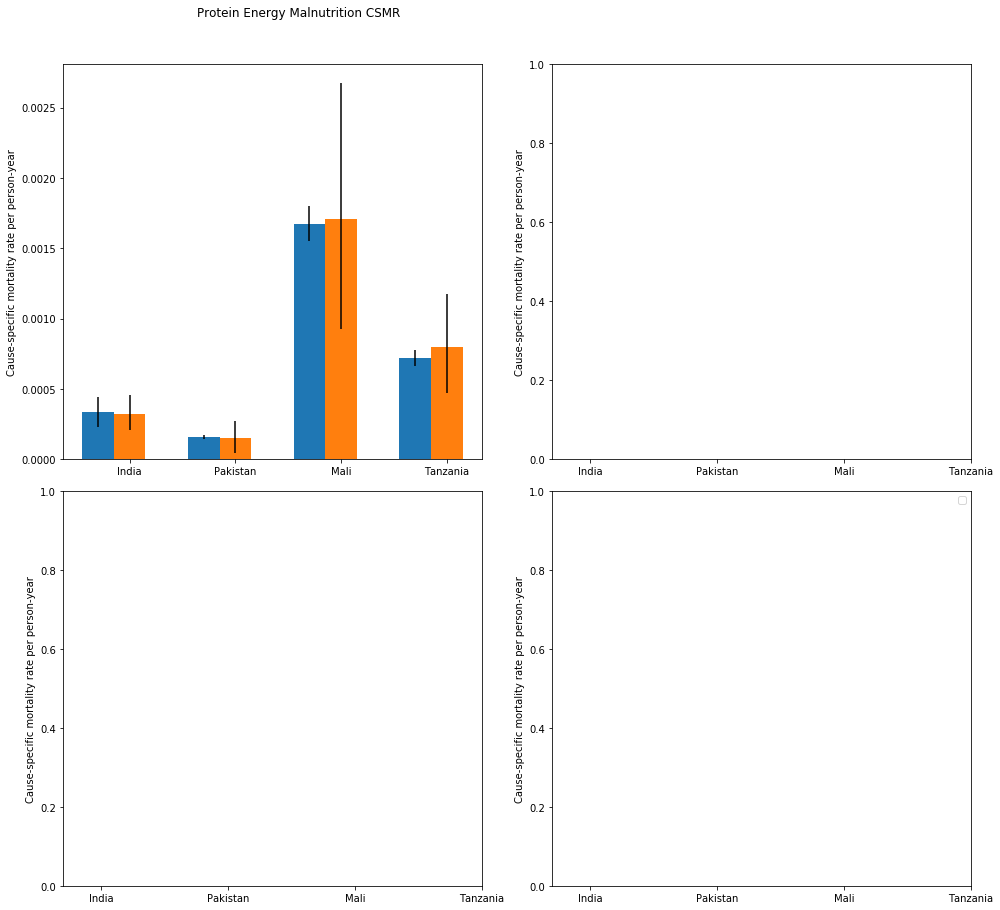

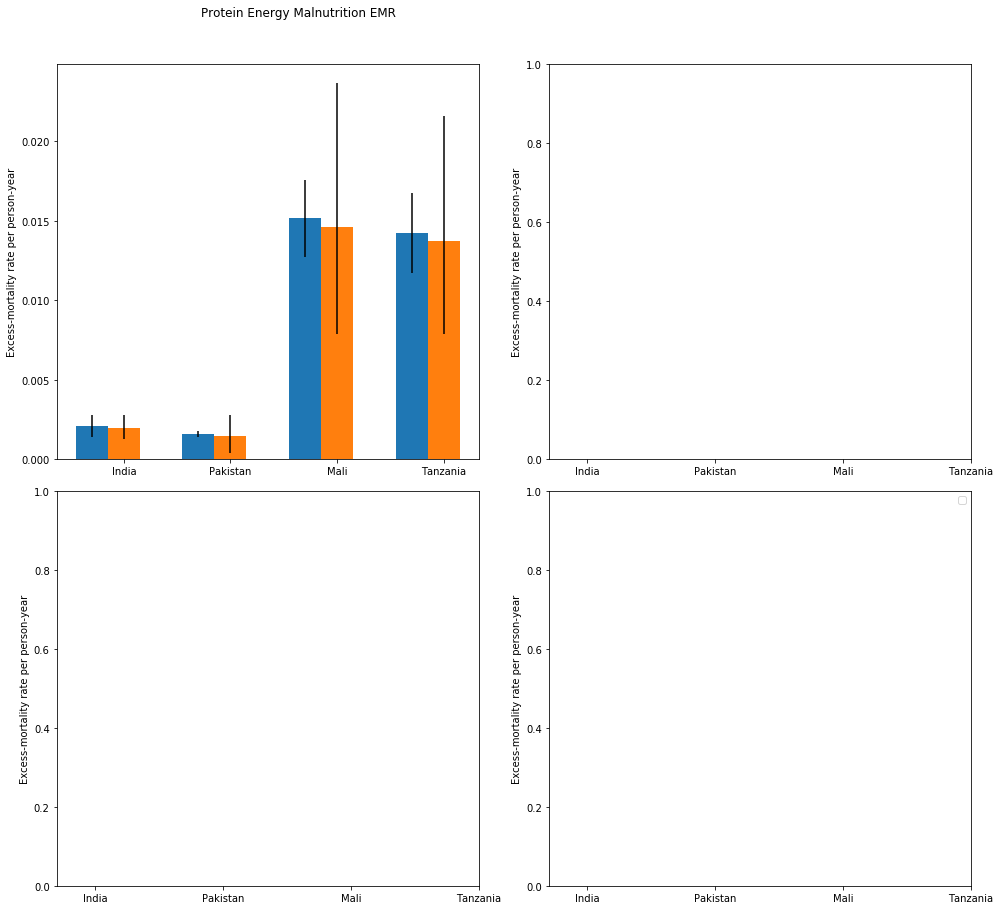

In [52]:
make_and_save_plots('protein_energy_malnutrition', pem_model, pem_artifact, 'Protein Energy Malnutrition', 'pem')

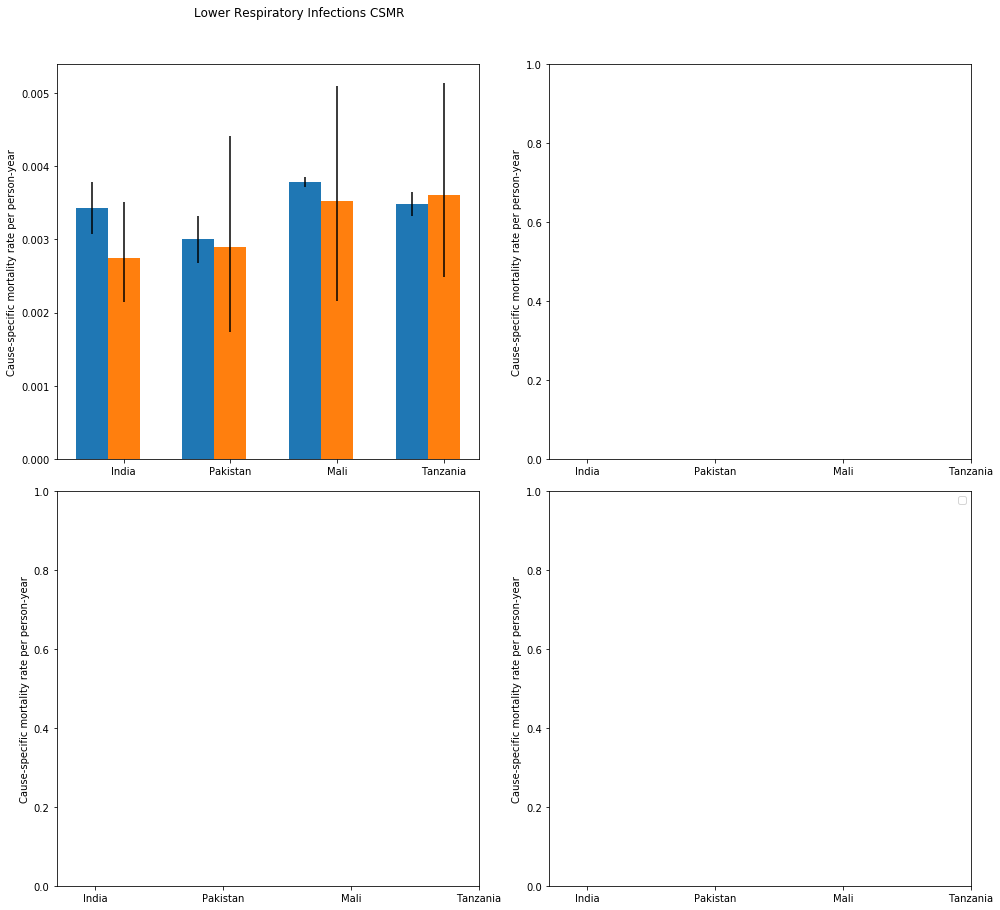

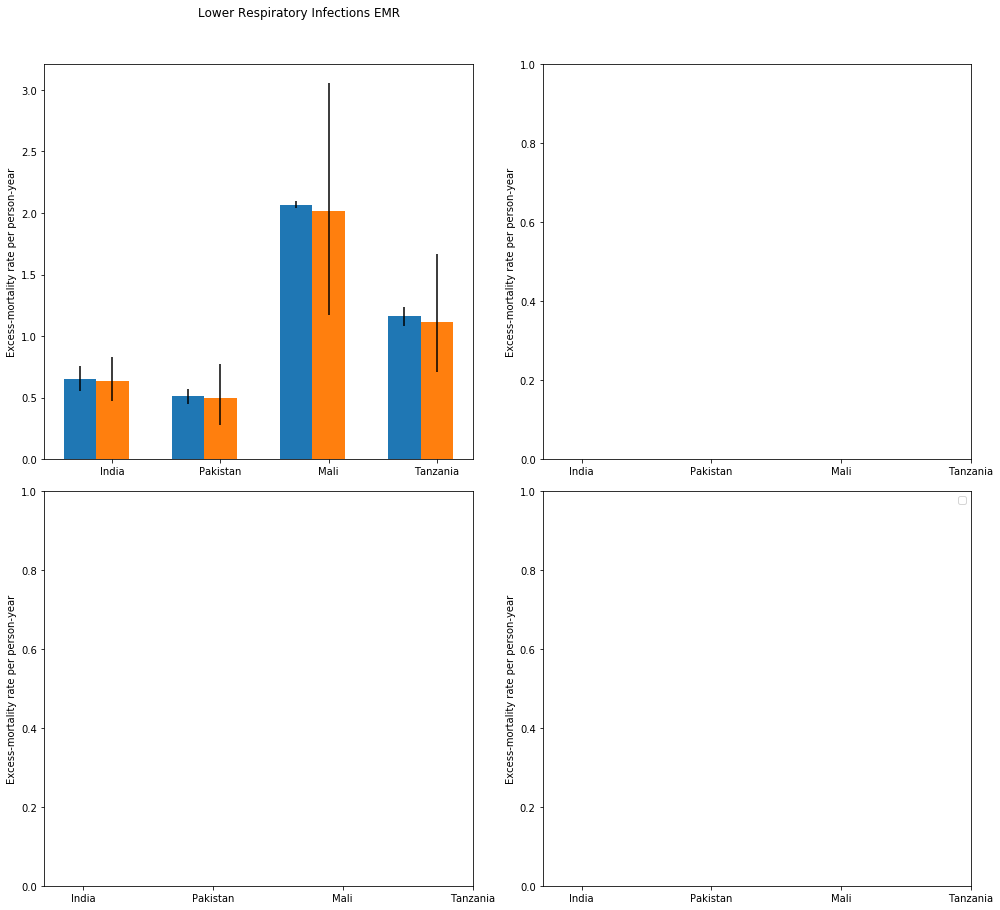

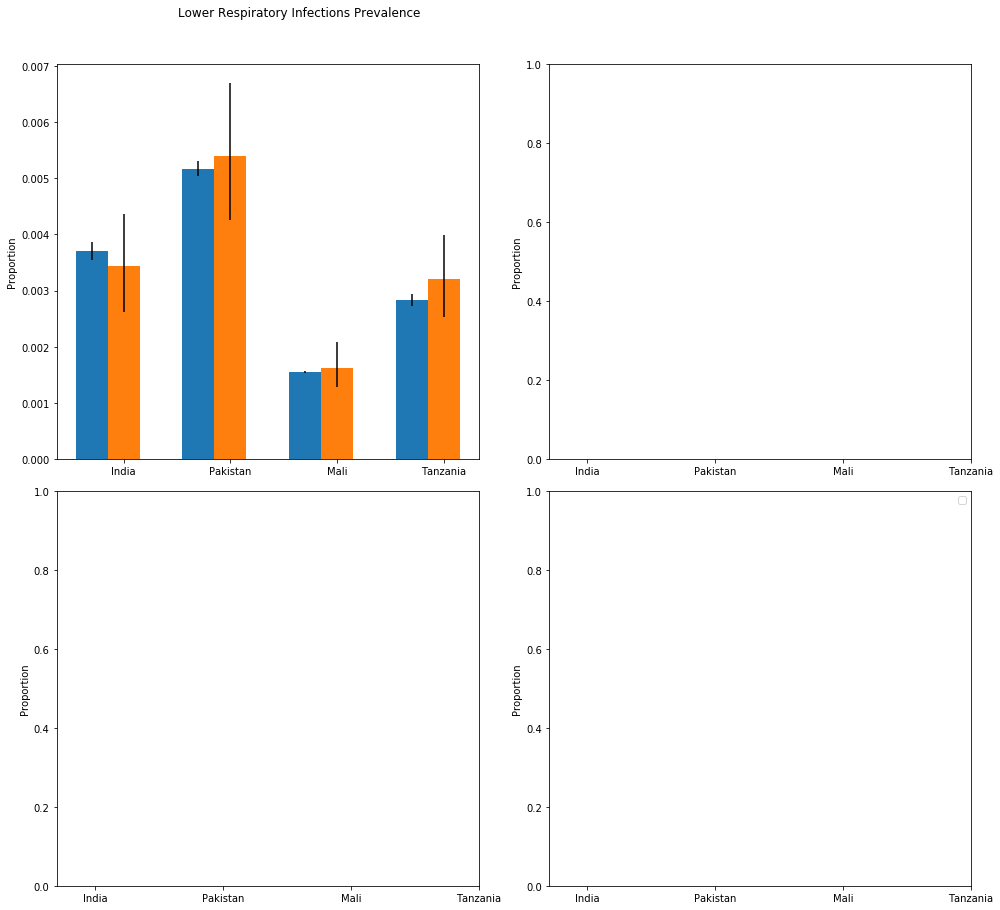

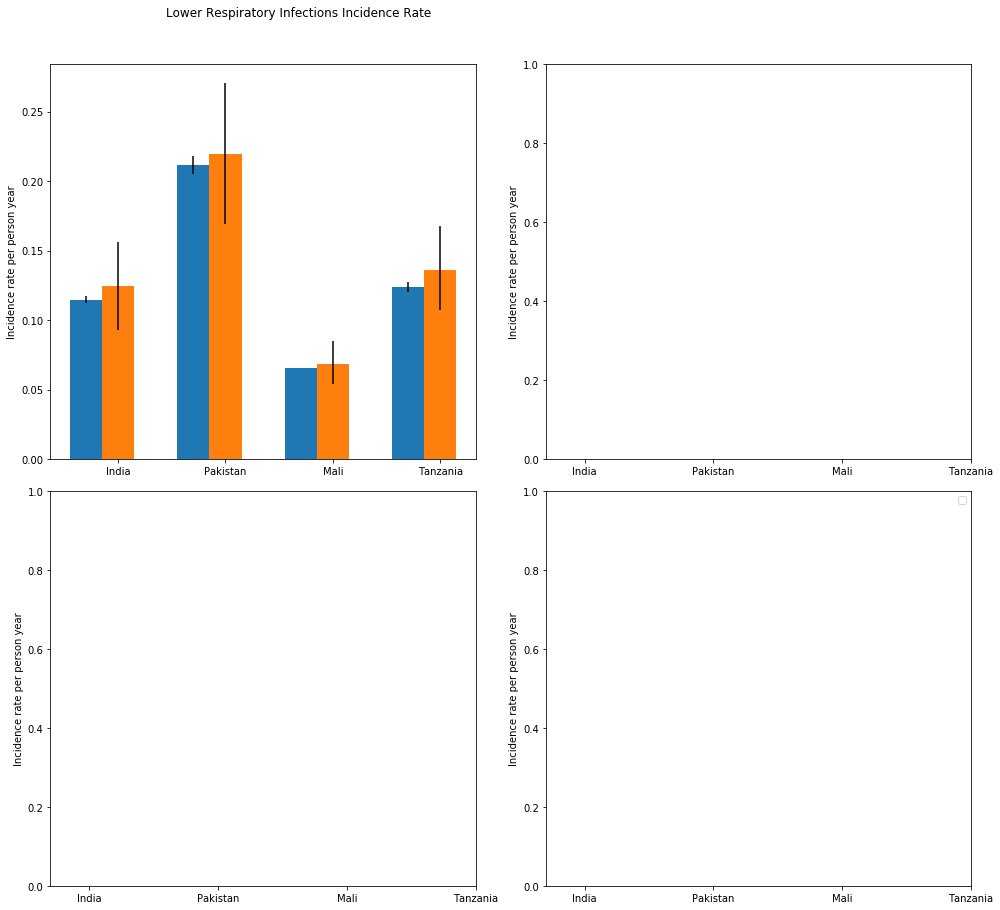

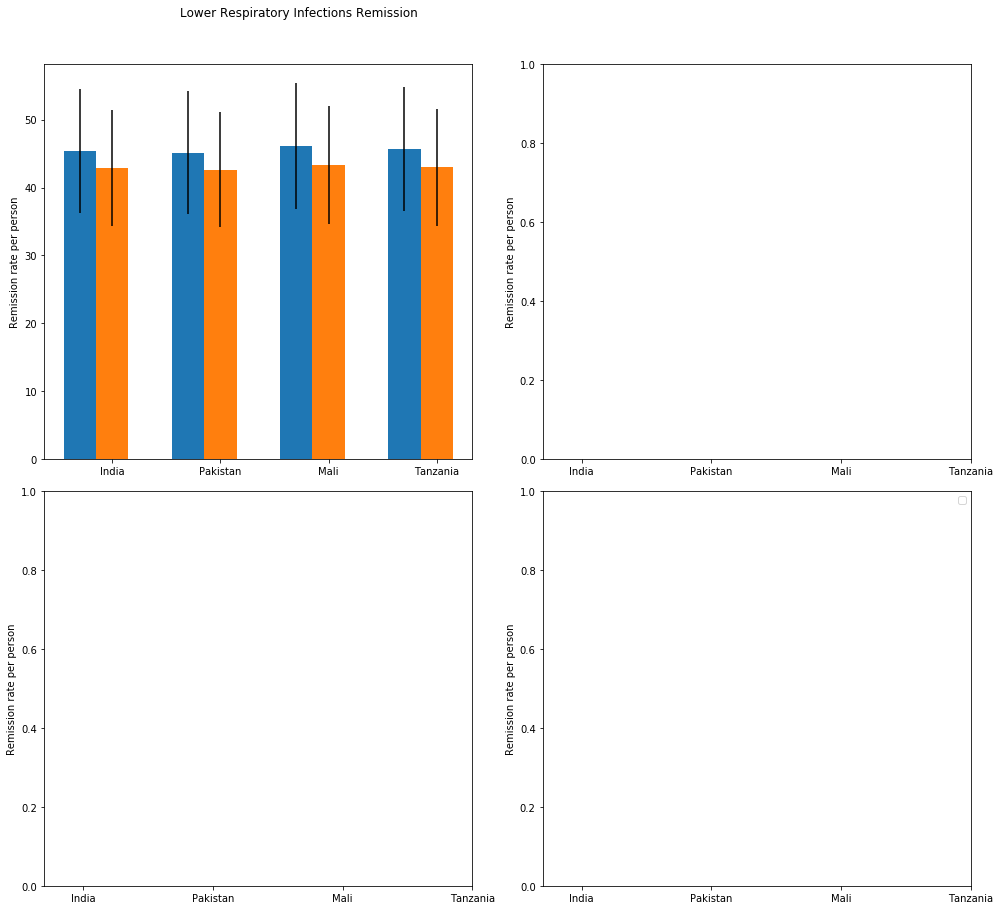

In [48]:
make_and_save_plots('lower_respiratory_infections', lri_model, lri_artifact, 'Lower Respiratory Infections', 'lri')

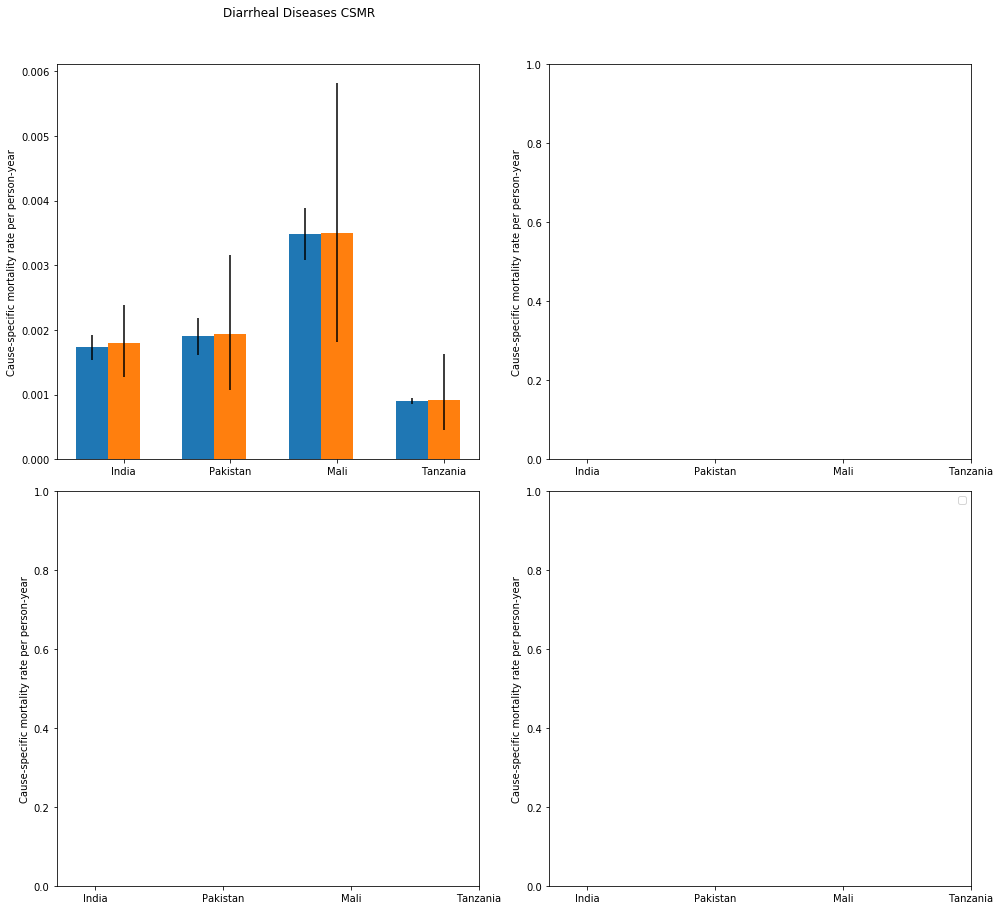

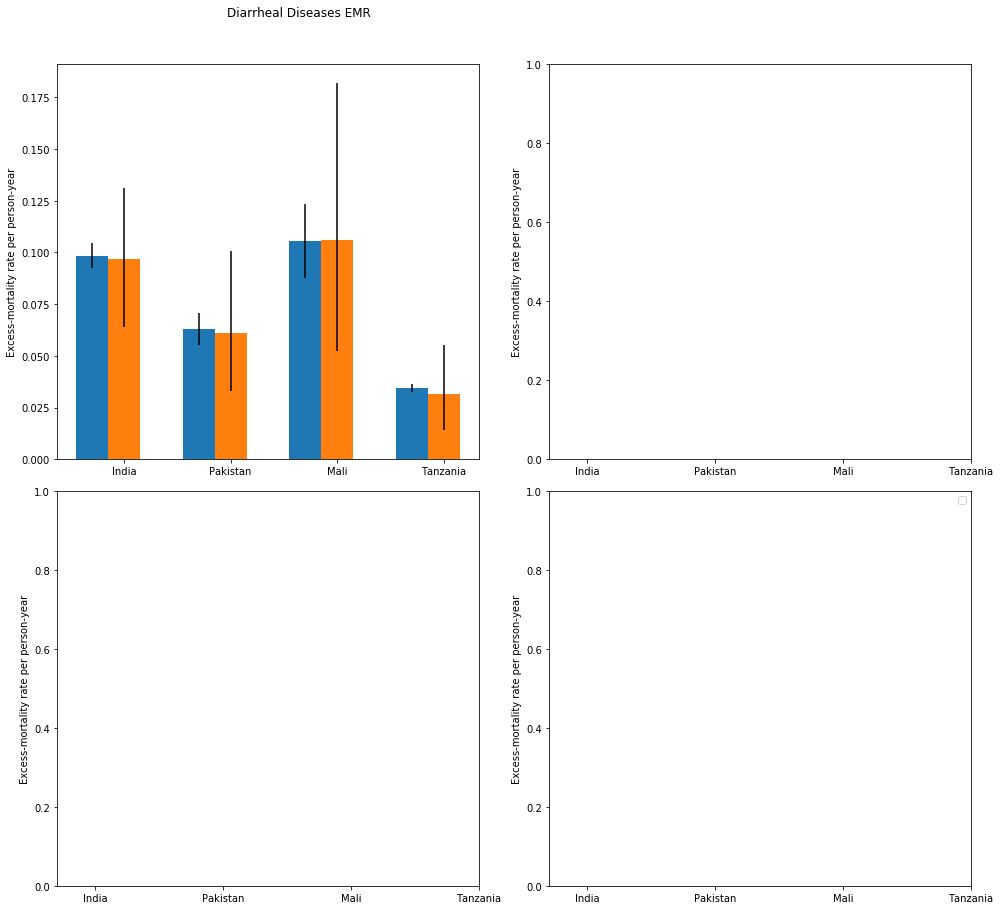

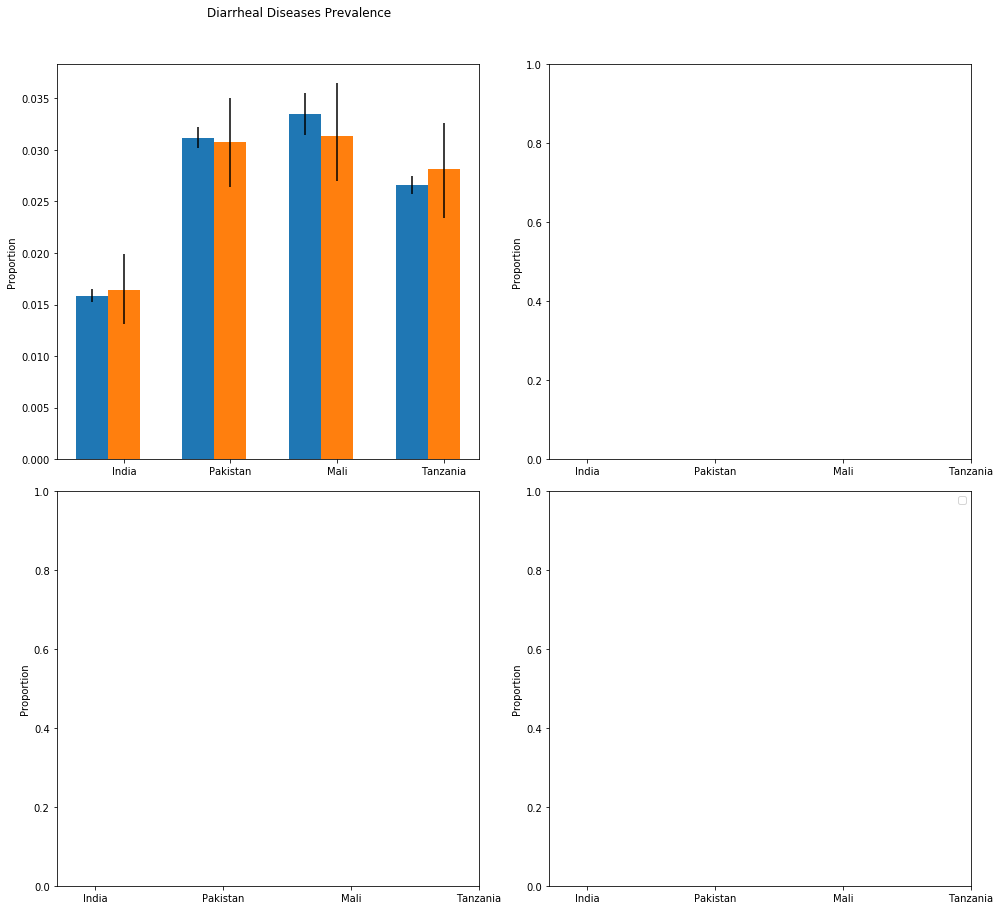

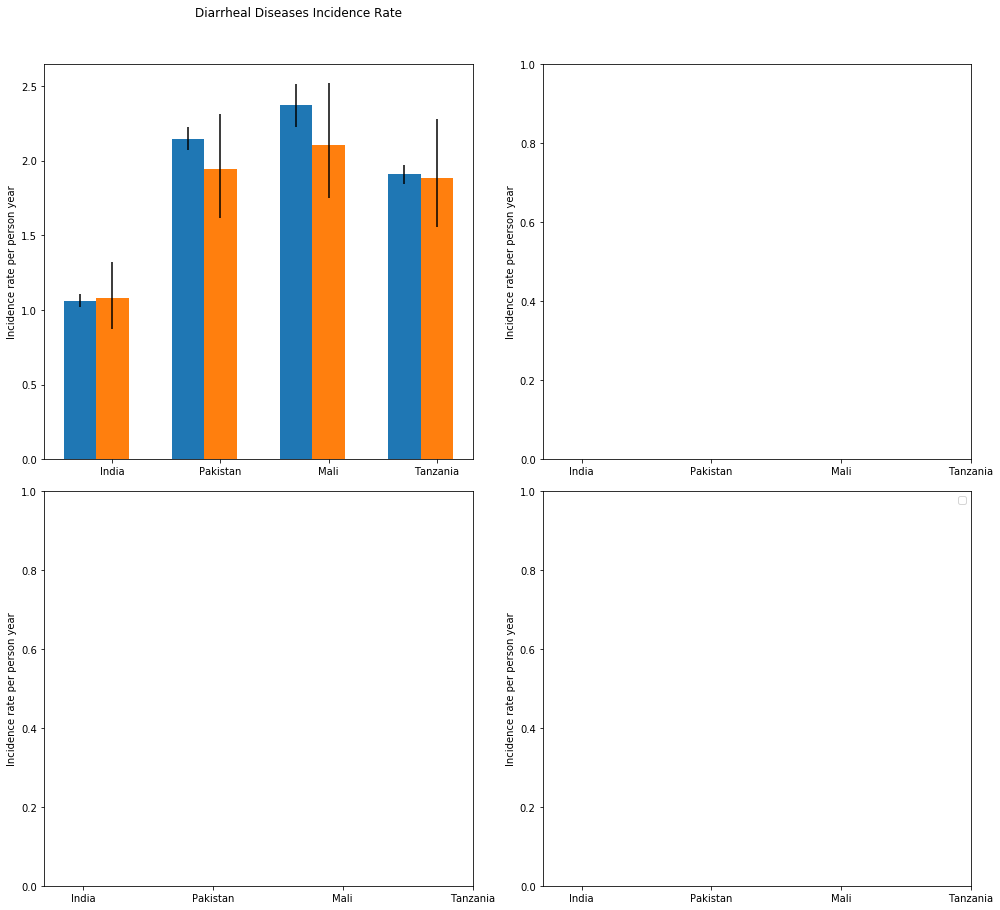

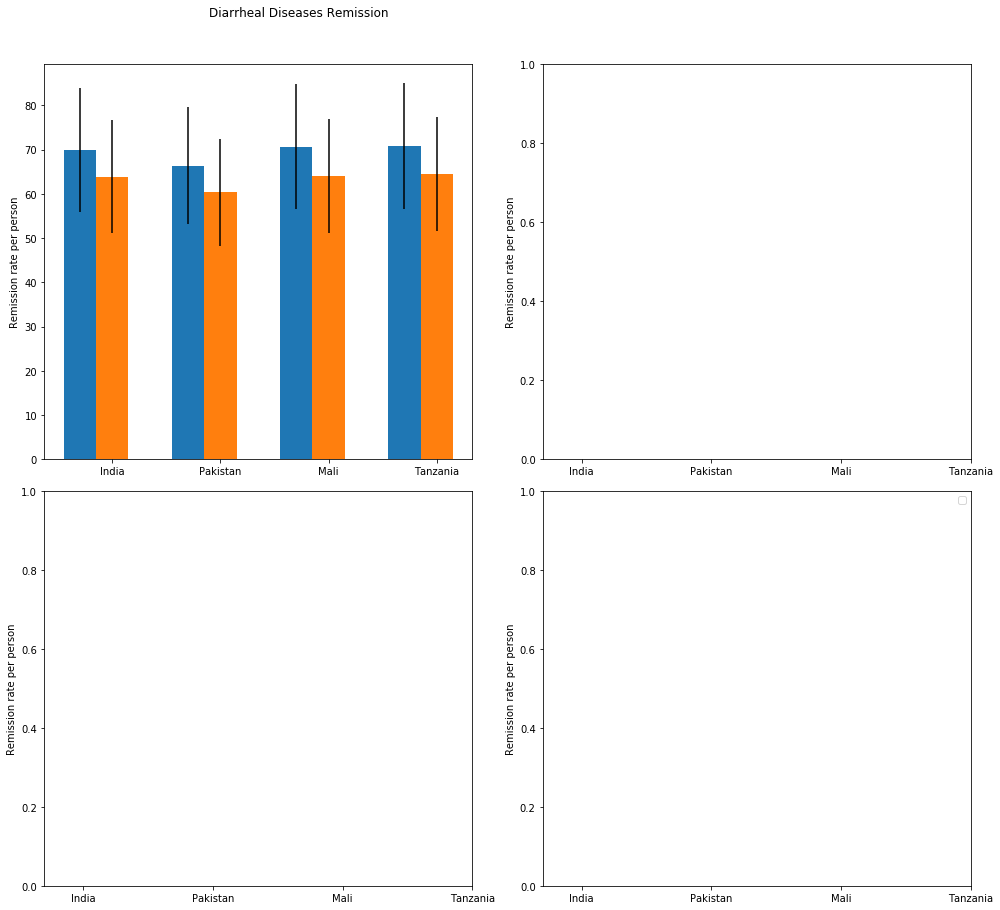

In [49]:
make_and_save_plots('diarrheal_diseases', dd_model, dd_artifact, 'Diarrheal Diseases', 'dd')

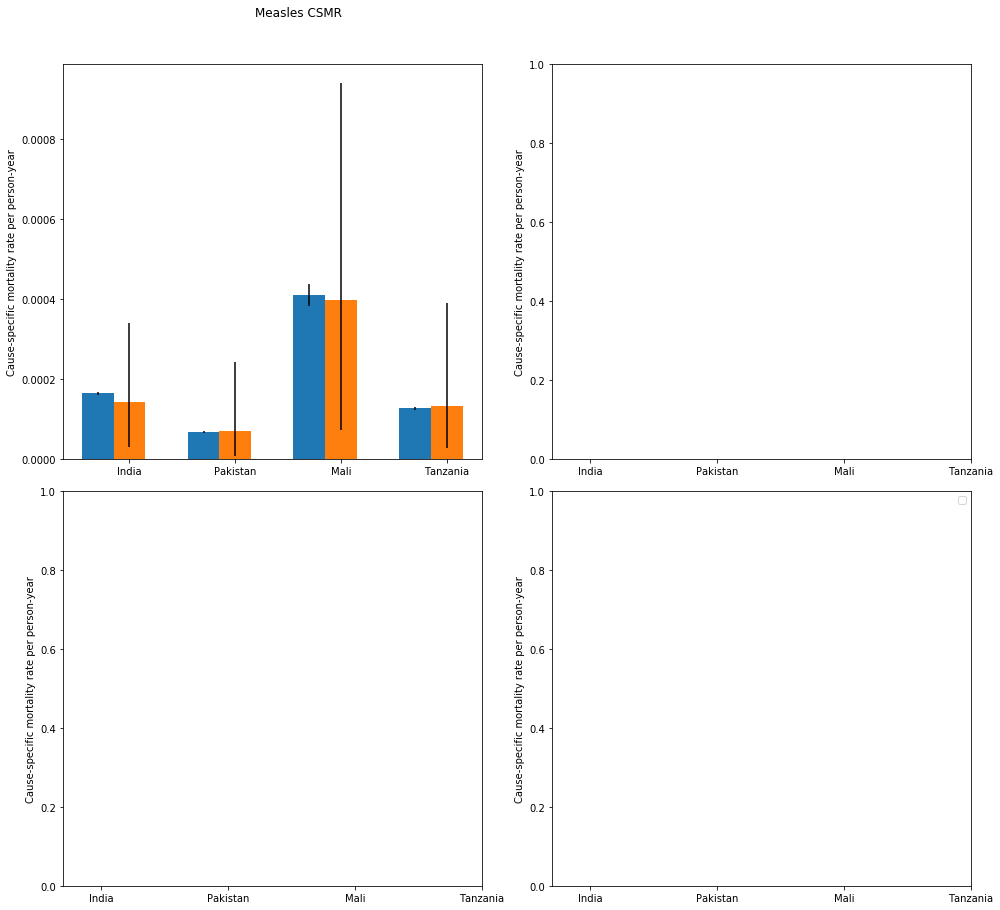

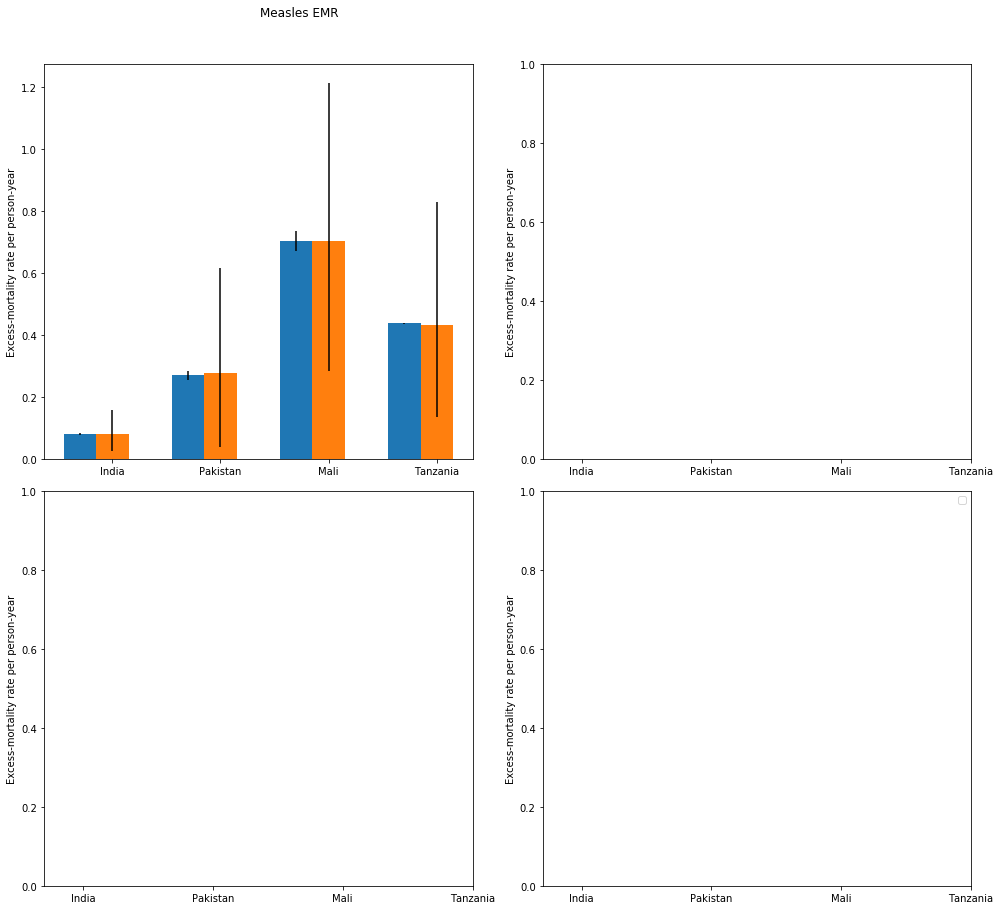

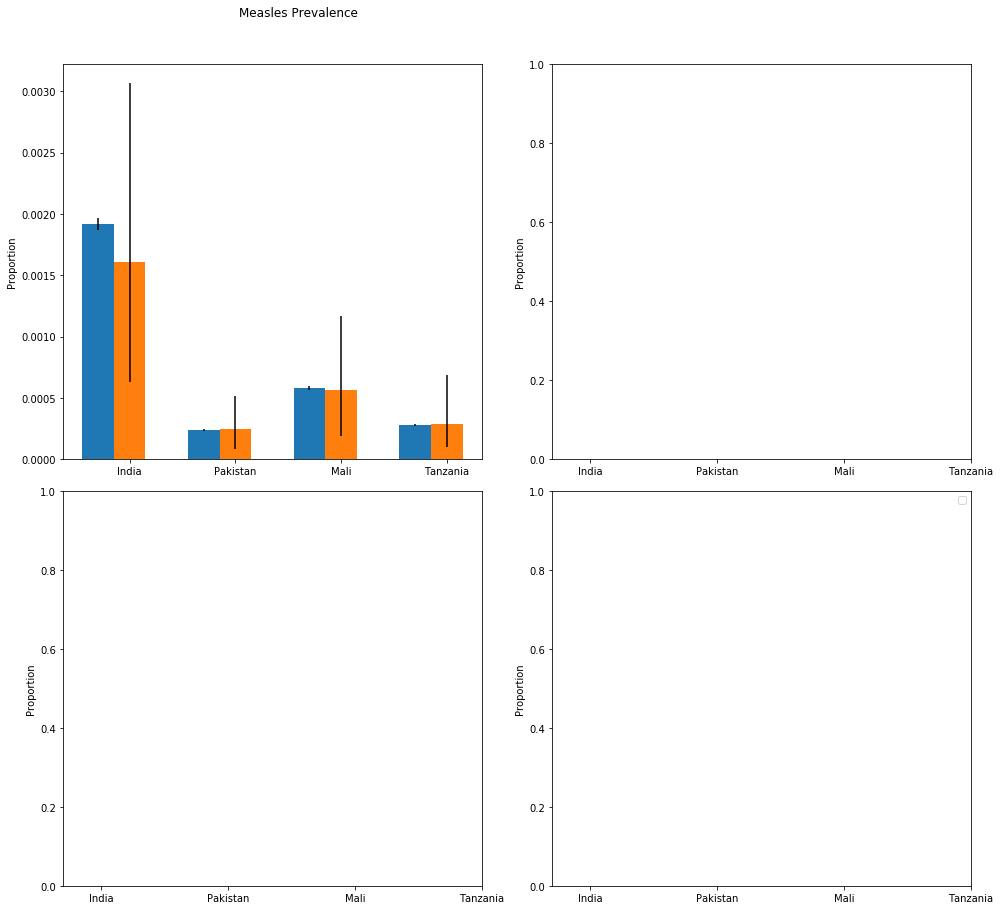

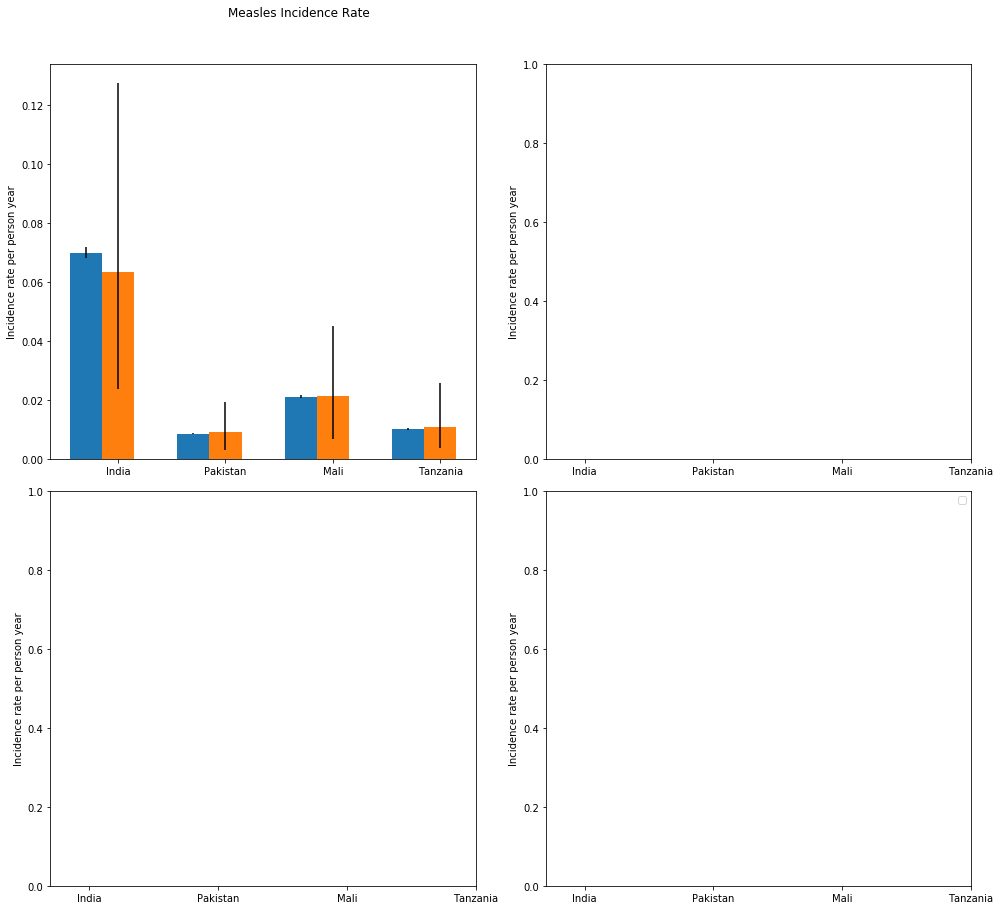

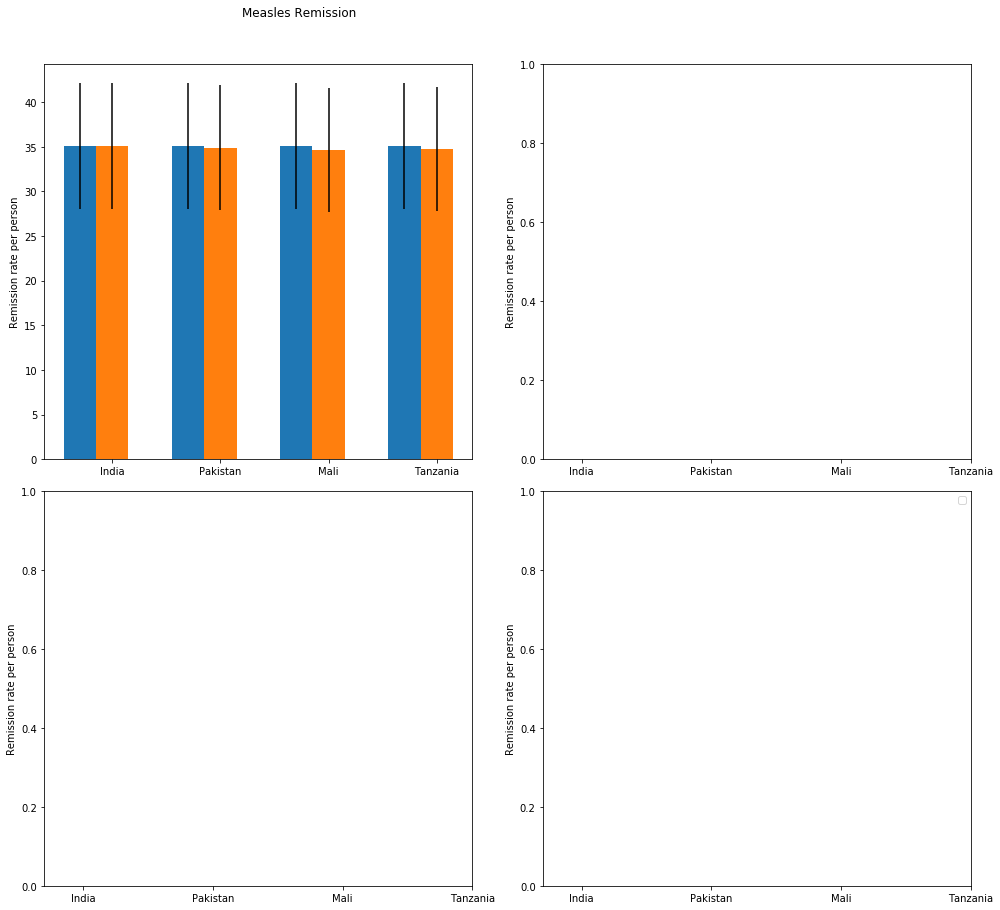

In [50]:
make_and_save_plots('measles', measles_model, measles_artifact, 'Measles', 'measles')